In [13]:
import os
os.chdir('..')


In [3]:
import time

import numpy as np
import pickle
import scipy.io as scio
import torch
from scipy import stats
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from thop import clever_format
from thop import profile
from sklearn import metrics
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab 

from dataset import monoSimDataset
from model.loss import FocalLoss, CrossEntropy2d
from model.quality_model import MobileNetV2_Lite

In [4]:
dataset_path = 'data/TJ-Eyes'
cp_path = "checkpoints/1211_202056_MobileNetV2_Lite_TJ-Eyes/13_1.4457e-02.pth"
seed = 2248
device = 'cuda:0'

In [5]:
if torch.cuda.is_available() and device is not None:
    device = torch.device(device)
else:
    if not torch.cuda.is_available():
        print("hey man, buy a GPU!")
    device = torch.device("cpu")

In [8]:
test_data = monoSimDataset(path=dataset_path, mode='test', seed=seed, debug_data=False)
test_data_loader = DataLoader(test_data, 1, shuffle=False, drop_last=False)

print(len(test_data))

1082


In [9]:
model = MobileNetV2_Lite()
assert model is not None
model.to(device)
assert cp_path is not ''
cp_data = torch.load(cp_path, map_location=device)
try:
    model.load_state_dict(cp_data['model'])
except Exception as e:
    model.load_state_dict(cp_data['model'], strict=False)
    print(e)

cp_data['cfg'] = '' if 'cfg' not in cp_data else cp_data['cfg']
print(cp_data['cfg'])

Error(s) in loading state_dict for MobileNetV2_Lite:
	Unexpected key(s) in state_dict: "decoder.b0.1.weight", "decoder.b0.1.bias", "decoder.b0.1.running_mean", "decoder.b0.1.running_var", "decoder.b0.1.num_batches_tracked". 
info=finetune on TJ
dataset_path=/home/dl/wangleyuan/dataset/TJ-Eyes
cp_path=checkpoints/1203_202301_MobileNetV2_Lite/421_1.3395e-03.pth
cp_num=5
visible=True
model=MobileNetV2_Lite
seed=2248
debug=False
mask_learn_rate=0.5
mask_lr_decay=1
upout=True
batch_size=24
device=cuda:2
num_workers=2
max_epochs=250
lr=0.0004
momentum=0.9
weight_decay=0.002
name=1211_202056_MobileNetV2_Lite_TJ-Eyes



In [11]:
test_pred_loss = 0
scores = np.zeros((1))
prediction = np.zeros((1))
names = []
heatmaps = []
time_spend = 0

model.train(False)
with torch.no_grad():
    for img, mask, target, name in tqdm(test_data_loader, desc='Test_batch', bar_format='{desc}: {n_fmt}/{total_fmt} -{percentage:3.0f}%'):
        img = img.to(device)
        target = target.to(device)
        
        start = time.time()
        pred, heatmap = model(img)
        time_spend += time.time()- start
        
        test_pred_loss += nn.functional.mse_loss(pred, target, reduction='sum')

        heatmap = torch.softmax(heatmap, 1)[0, 1, :, :]
        heatmap = heatmap.cpu().numpy()

        names.append(name[0])
        heatmaps.append(heatmap)
        scores = np.append(scores, target.cpu().numpy().reshape((-1)))
        prediction = np.append(prediction, pred.cpu().numpy().reshape((-1)))
     
scores = scores[1:]
prediction = prediction[1:]

Test_batch: 1082/1082 -100%


In [12]:
test_pred_loss = test_pred_loss / len(test_data)
time_spend /= len(test_data_loader)
# prediction = np.nan_to_num(prediction)
srocc = stats.spearmanr(prediction, scores)[0]
lcc = stats.pearsonr(prediction, scores)[0]

print("Test - Time: {:.4f}".format(time_spend))
print("Test - MSE: {:.1e}".format(test_pred_loss))
print("Test - LCC: {:.2f}".format(lcc))
print("Test - SROCC: {:.2f}".format(srocc))

Test - Time: 0.0193
Test - MSE: 1.5e-02
Test - LCC: 0.53
Test - SROCC: 0.58


In [8]:
print(scores.max(), scores.min())
print(prediction.max(), prediction.min())
print(scores)
print(prediction)


1.0000001192092896 0.43543463945388794
0.9865290522575378 0.6616989970207214
[1.         0.97514093 0.94535333 ... 0.78838027 0.79130769 0.75383806]
[0.78550935 0.75248873 0.73547232 ... 0.88072592 0.86717075 0.73184311]


In [9]:
device = torch.device('cuda:1')
time_spend = 0

model.train(False)
model.to(device)
with torch.no_grad():
    for img, mask, target, name in test_data_loader:
        img = img.to(device)
        mask = mask.to(device)
        target = target.to(device)
        
        start = time.time()
        pred, heatmap = model(img)
        time_spend += time.time()- start
        
time_spend /= len(test_data_loader)
print("Test - GPU Time: {:.4f}".format(time_spend))

device = torch.device('cpu')
time_spend = 0

model.train(False)
model.to(device)
with torch.no_grad():
    for img, mask, target, name in test_data_loader:
        img = img.to(device)
        mask = mask.to(device)
        target = target.to(device)
        
        start = time.time()
        pred, heatmap = model(img)
        time_spend += time.time()- start
        
time_spend /= len(test_data_loader)
print("Test - CPU Time: {:.4f}".format(time_spend))

Test - GPU Time: 0.0097


KeyboardInterrupt: 

In [10]:
flops, params = profile(model, inputs=(img, ))
flops, params = clever_format([flops, params], "%.3f")
print(flops, params)

Register FLOP counter for module Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Register FLOP counter for module BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Register FLOP counter for module ReLU6(inplace=True)
Register FLOP counter for module Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
Register FLOP counter for module BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Register FLOP counter for module ReLU6(inplace=True)
Register FLOP counter for module Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
Register FLOP counter for module BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Register FLOP counter for module Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
Register FLOP counter for module BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Register FLOP counte

2.049G 3.241M


In [11]:
def cal_DET(sim, labels):
    label_num = len(labels)
    sim = sim[~np.eye(label_num, dtype=np.bool)]
    if labels.max() == 1 and labels.min() == 0 and labels.shape[0] != labels.shape[1]:
        label = np.dot(labels, labels.T)
    else:
        label = np.zeros((label_num, label_num))
        for x in range(label_num):
            for y in range(label_num):
                label[x, y] = labels[x] == labels[y]
    label = label[~np.eye(label_num, dtype=np.bool)].astype(np.bool)

    fpr, tpr, thresholds = metrics.roc_curve(label, sim)
    fnr = 1 - tpr

    eer = fpr[np.argmin(np.abs(fpr - fnr))]
    roc_auc = metrics.auc(fpr, tpr)
    return eer, fnr, tpr, roc_auc, thresholds

In [12]:
sim = scio.loadmat(os.path.join(dataset_path, 'sim.mat'))['sim']
with open(os.path.join(dataset_path, 'gallery.txt'), 'r') as f:
    gallery_dict = {x.strip().split(' ')[1]: x.strip().split(' ')[0] for x in f.readlines()}
with open(os.path.join(dataset_path, 'test.txt'), 'r') as f:
    img_list = [tuple(line.strip().split(' ')) for line in f.readlines()]
img_dict ={x[0]:(x[1],x[2]) for x in img_list}

In [13]:
test_names = {x[0]:idx for idx, x in enumerate(img_list)}
test_sim = np.zeros((len(img_list), len(img_list)))
for tx , d in enumerate(img_list):
    sx = int(d[2])
    for ty, d in enumerate(img_list):
        sy = int(d[2])
        test_sim[tx, ty] = sim[sx,sy]


In [14]:
labels = np.array([int(x[1]) for x in img_list])
eer, fnr, tpr, roc_auc, thresholds = cal_DET(test_sim, labels)
print(eer)

0.2859270222368397


In [15]:
t_eer_list = []
t_irr_list = []
t_auc_list = []
thr_list = np.arange(0.4,1,0.6/100)
for thr in tqdm(thr_list, desc='eer-irr', bar_format='{desc}: {n_fmt}/{total_fmt} -{percentage:3.0f}%'):
    try:
        cur_names = []
        for i,s in enumerate(scores):
            if s > thr:
                cur_names.append(names[i])
        cur_labels = np.array([int(img_dict[x][0]) for x in cur_names])
        cur_sim = np.zeros((len(cur_names), len(cur_names)))
        for tx , d in enumerate(cur_names):
            sx = int(img_dict[d][1])
            for ty, d in enumerate(cur_names):
                sy = int(img_dict[d][1])
                cur_sim[tx, ty] = sim[sx,sy]
        eer, _, _, roc_auc, _ = cal_DET(cur_sim, cur_labels)
        irr = 1 - len(cur_names) / len(test_names)
        t_eer_list.append(eer)
        t_irr_list.append(irr)
    except Exception as e:
        print(e)

eer-irr: 96/100 - 96%/home/dl/wangleyuan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
eer-irr: 100/100 -100%


In [16]:
p_eer_list = []
p_irr_list = []
p_auc_list = []
thr_list = np.arange(0.6,1.1,0.5/100)
for thr in tqdm(thr_list, desc='eer-irr', bar_format='{desc}: {n_fmt}/{total_fmt} -{percentage:3.0f}%'):
    try:
        cur_names = []
        for i,s in enumerate(prediction):
            if s > thr:
                cur_names.append(names[i])
        cur_labels = np.array([int(img_dict[x][0]) for x in cur_names])
        cur_sim = np.zeros((len(cur_names), len(cur_names)))
        for tx , d in enumerate(cur_names):
            sx = int(img_dict[d][1])
            for ty, d in enumerate(cur_names):
                sy = int(img_dict[d][1])
                cur_sim[tx, ty] = sim[sx,sy]
        eer, _, _, roc_auc, _ = cal_DET(cur_sim, cur_labels)
        irr = 1 - len(cur_names) / len(test_names)
        p_eer_list.append(eer)
        p_irr_list.append(irr)
    except Exception as e:
        print(e)

eer-irr: 62/101 - 61%/home/dl/wangleyuan/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
eer-irr: 101/101 -100%

Data is not binary and pos_label is not specified
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which 

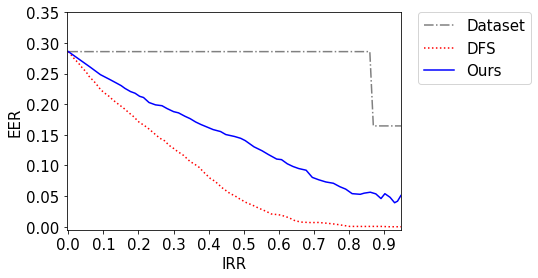

In [165]:
x = np.arange(0,1,0.01)
y = np.ones((100,1))
y[:87] = 0.2859
y[87:] = 0.1646

plt.figure()
plt.plot(x, y, linestyle='-.',color='gray', label='Dataset')
plt.plot(t_irr_list, t_eer_list, color='r',linestyle=':',  label='DFS')
plt.plot(p_irr_list, p_eer_list, color='b', label='Ours')

plt.xlim(-0.005,0.95)
plt.ylim(-0.005,0.35)
plt.xlabel('IRR', fontsize=15)
plt.ylabel('EER', fontsize=15)
plt.xticks(np.arange(0,1,0.1), fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0, fontsize=15)
plt.savefig('result/eer_irr_TJ.png')
plt.show()

sharpness, iris_size, dilation, gray_level_spread, usable_area

In [18]:
with open('tj_test_quality.txt', 'r') as f:
    qdata = [x.strip() for x in f.readlines()]
qdict = {x.split(',')[0]:[float(y) for y in x.split(',')[1].split(' ')[1:]] for x in qdata}

qarray = np.zeros((len(qdict),5))
for idx,n in enumerate(qdict.keys()):
    qarray[idx,:] = np.array(qdict[n])

In [19]:
fm = qarray[:, 0]
size = qarray[:, 1]
dilation = qarray[:, 2]
gls = qarray[:, 3]
uar = qarray[:, 4]

In [113]:
srocc = stats.spearmanr(fm, scores)[0]
lcc = stats.pearsonr(fm, scores)[0]
print("fm - LCC: {:.2f} SROCC: {:.2f}".format(lcc, srocc))
srocc = stats.spearmanr(size, scores)[0]
lcc = stats.pearsonr(size, scores)[0]
print("size - LCC: {:.2f} SROCC: {:.2f}".format(lcc, srocc))
srocc = stats.spearmanr(dilation, scores)[0]
lcc = stats.pearsonr(dilation, scores)[0]
print("dilation - LCC: {:.2f} SROCC: {:.2f}".format(lcc, srocc))
srocc = stats.spearmanr(gls, scores)[0]
lcc = stats.pearsonr(gls, scores)[0]
print("gls - LCC: {:.2f} SROCC: {:.2f}".format(lcc, srocc))
srocc = stats.spearmanr(uar, scores)[0]
lcc = stats.pearsonr(uar, scores)[0]
print("uar - LCC: {:.2f} SROCC: {:.2f}".format(lcc, srocc))

fm - LCC: 0.28 SROCC: 0.27
size - LCC: 0.11 SROCC: 0.21
dilation - LCC: 0.14 SROCC: 0.17
gls - LCC: 0.14 SROCC: 0.15
uar - LCC: 0.14 SROCC: 0.12


Text(0, 0.5, 'count')

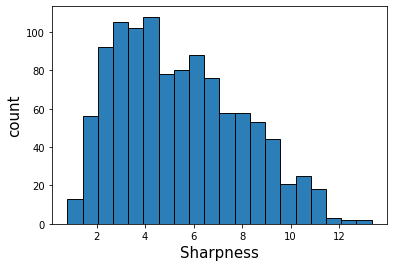

In [21]:
plt.hist(fm,bins=20, edgecolor='k', alpha=0.95)
plt.xlabel('Sharpness', fontsize=15)
plt.ylabel('count', fontsize=15)

Text(0, 0.5, 'count')

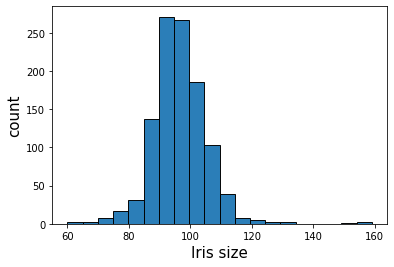

In [22]:
plt.hist(size,bins=20, edgecolor='k', alpha=0.95)
plt.xlabel('Iris size', fontsize=15)
plt.ylabel('count', fontsize=15)

Text(0, 0.5, 'count')

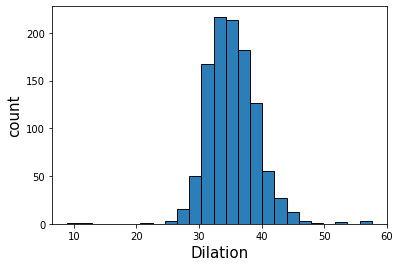

In [23]:
plt.hist(dilation,bins=25, edgecolor='k', alpha=0.95)
plt.xlabel('Dilation', fontsize=15)
plt.ylabel('count', fontsize=15)

Text(0, 0.5, 'count')

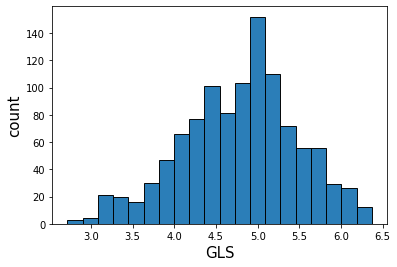

In [24]:
plt.hist(gls,bins=20, edgecolor='k', alpha=0.95)
plt.xlabel('GLS', fontsize=15)
plt.ylabel('count', fontsize=15)

Text(0, 0.5, 'count')

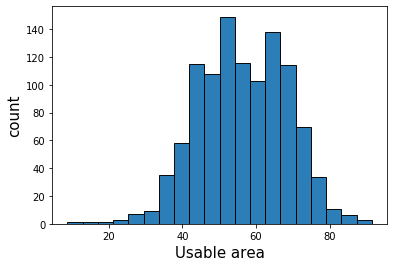

In [25]:
plt.hist(uar,bins=20, edgecolor='k', alpha=0.95)
plt.xlabel('Usable area', fontsize=15)
plt.ylabel('count', fontsize=15)

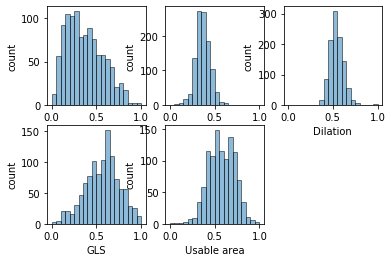

In [130]:
plt.subplot(231)
plt.hist(fm,bins=20, edgecolor='k', alpha=0.5)
plt.xlabel('Sharpness')
plt.ylabel('count')
plt.subplot(232)
plt.hist(size, bins=20, edgecolor='k', alpha=0.5)
plt.ylabel('count')
plt.xlabel('Iris size')
plt.subplot(233)
plt.hist(dilation, bins=20, edgecolor='k', alpha=0.5)
plt.ylabel('count')
plt.xlabel('Dilation')
plt.subplot(234)
plt.hist(gls, bins=20, edgecolor='k', alpha=0.5)
plt.ylabel('count')
plt.xlabel('GLS')
plt.subplot(235)
plt.hist(uar, bins=20, edgecolor='k', alpha=0.5)
plt.ylabel('count')
plt.xlabel('Usable area')

plt.show()

In [143]:
fm = qarray[:, 0]
size = qarray[:, 1]
dilation = qarray[:, 2]
gls = qarray[:, 3]
uar = qarray[:, 4]

fm = (fm - fm.min())/(fm.max()-fm.min())
size = (size - size.min())/(size.max()-size.min())
dilation = (dilation - dilation.min())/(dilation.max()-dilation.min())
gls = (gls - gls.min())/(gls.max()-gls.min())
uar = (uar - uar.min())/(uar.max()-uar.min())

# fm /= fm.max()
# size /= size.max()
# dilation /= dilation.max()
# gls /= gls.max()
# uar /= uar.max()

In [144]:
fm_eer_list = []
fm_irr_list = []
thr_list = np.arange(0,0.5,1/100)
for thr in tqdm(thr_list, desc='eer-irr', bar_format='{desc}: {n_fmt}/{total_fmt} -{percentage:3.0f}%'):
    try:
        cur_names = []
        for i,s in enumerate(fm):
            if s > 0.5 - thr and s < 0.5 + thr:
                cur_names.append(names[i])
        cur_labels = np.array([int(img_dict[x][0]) for x in cur_names])
        cur_sim = np.zeros((len(cur_names), len(cur_names)))
        for tx , d in enumerate(cur_names):
            sx = int(img_dict[d][1])
            for ty, d in enumerate(cur_names):
                sy = int(img_dict[d][1])
                cur_sim[tx, ty] = sim[sx,sy]
        eer, _, _, roc_auc, _ = cal_DET(cur_sim, cur_labels)
        irr = 1 - len(cur_names) / len(test_names)
        fm_eer_list.append(eer)
        fm_irr_list.append(irr)
    except Exception as e:
        print(e)

eer-irr: 7/50 - 14%

zero-size array to reduction operation maximum which has no identity


eer-irr: 50/50 -100%


In [145]:
size_eer_list = []
size_irr_list = []
thr_list = np.arange(0,0.5,1/100)
for thr in tqdm(thr_list, desc='eer-irr', bar_format='{desc}: {n_fmt}/{total_fmt} -{percentage:3.0f}%'):
    try:
        cur_names = []
        for i,s in enumerate(size):
            if s > 0.5 - thr and s < 0.5 + thr:
                cur_names.append(names[i])
        cur_labels = np.array([int(img_dict[x][0]) for x in cur_names])
        cur_sim = np.zeros((len(cur_names), len(cur_names)))
        for tx , d in enumerate(cur_names):
            sx = int(img_dict[d][1])
            for ty, d in enumerate(cur_names):
                sy = int(img_dict[d][1])
                cur_sim[tx, ty] = sim[sx,sy]
        eer, _, _, roc_auc, _ = cal_DET(cur_sim, cur_labels)
        irr = 1 - len(cur_names) / len(test_names)
        size_eer_list.append(eer)
        size_irr_list.append(irr)
    except Exception as e:
        print(e)

eer-irr: 6/50 - 12%

zero-size array to reduction operation maximum which has no identity


eer-irr: 50/50 -100%


In [146]:
dilation_eer_list = []
dilation_irr_list = []
thr_list = np.arange(0,0.5,1/100)
for thr in tqdm(thr_list, desc='eer-irr', bar_format='{desc}: {n_fmt}/{total_fmt} -{percentage:3.0f}%'):
    try:
        cur_names = []
        for i,s in enumerate(dilation):
            if s > 0.5 - thr and s < 0.5 + thr:
                cur_names.append(names[i])
        cur_labels = np.array([int(img_dict[x][0]) for x in cur_names])
        cur_sim = np.zeros((len(cur_names), len(cur_names)))
        for tx , d in enumerate(cur_names):
            sx = int(img_dict[d][1])
            for ty, d in enumerate(cur_names):
                sy = int(img_dict[d][1])
                cur_sim[tx, ty] = sim[sx,sy]
        eer, _, _, roc_auc, _ = cal_DET(cur_sim, cur_labels)
        irr = 1 - len(cur_names) / len(test_names)
        dilation_eer_list.append(eer)
        dilation_irr_list.append(irr)
    except Exception as e:
        print(e)

eer-irr: 3/50 -  6%

zero-size array to reduction operation maximum which has no identity


eer-irr: 50/50 -100%


In [147]:
gls_eer_list = []
gls_irr_list = []
thr_list = np.arange(0,0.5,1/100)
for thr in tqdm(thr_list, desc='eer-irr', bar_format='{desc}: {n_fmt}/{total_fmt} -{percentage:3.0f}%'):
    try:
        cur_names = []
        for i,s in enumerate(gls):
            if s > 0.5 - thr and s < 0.5 + thr:
                cur_names.append(names[i])
        cur_labels = np.array([int(img_dict[x][0]) for x in cur_names])
        cur_sim = np.zeros((len(cur_names), len(cur_names)))
        for tx , d in enumerate(cur_names):
            sx = int(img_dict[d][1])
            for ty, d in enumerate(cur_names):
                sy = int(img_dict[d][1])
                cur_sim[tx, ty] = sim[sx,sy]
        eer, _, _, roc_auc, _ = cal_DET(cur_sim, cur_labels)
        irr = 1 - len(cur_names) / len(test_names)
        gls_eer_list.append(eer)
        gls_irr_list.append(irr)
    except Exception as e:
        print(e)

eer-irr: 5/50 - 10%

zero-size array to reduction operation maximum which has no identity


eer-irr: 50/50 -100%


In [148]:
uar_eer_list = []
uar_irr_list = []
thr_list = np.arange(0,0.5,1/100)
for thr in tqdm(thr_list, desc='eer-irr', bar_format='{desc}: {n_fmt}/{total_fmt} -{percentage:3.0f}%'):
    try:
        cur_names = []
        for i,s in enumerate(uar):
            if s > 0.5 - thr and s < 0.5 + thr:
                cur_names.append(names[i])
        cur_labels = np.array([int(img_dict[x][0]) for x in cur_names])
        cur_sim = np.zeros((len(cur_names), len(cur_names)))
        for tx , d in enumerate(cur_names):
            sx = int(img_dict[d][1])
            for ty, d in enumerate(cur_names):
                sy = int(img_dict[d][1])
                cur_sim[tx, ty] = sim[sx,sy]
        eer, _, _, roc_auc, _ = cal_DET(cur_sim, cur_labels)
        irr = 1 - len(cur_names) / len(test_names)
        uar_eer_list.append(eer)
        uar_irr_list.append(irr)
    except Exception as e:
        print(e)

eer-irr: 4/50 -  8%

zero-size array to reduction operation maximum which has no identity


eer-irr: 50/50 -100%


In [149]:
saved = {'uar_eer':uar_eer_list, 'uar_irr':uar_irr_list, 'gls_eer':gls_eer_list, 'gls_irr':gls_irr_list,'dilation_eer':dilation_eer_list, 'dilation_irr':dilation_irr_list,'size_eer':size_eer_list, 'size_irr':size_irr_list,'fm_eer':fm_eer_list, 'fm_irr':fm_irr_list,'p_eer':p_eer_list, 'p_irr':p_irr_list,'t_eer':t_eer_list, 't_irr':t_irr_list}

In [150]:
import  pickle
with open('result/result_tj.pkl', 'wb') as f:
    pickle.dump(saved,f)
# with open('result/result_tj.pkl', 'rb') as f:
#     saved2 = pickle.load(f)

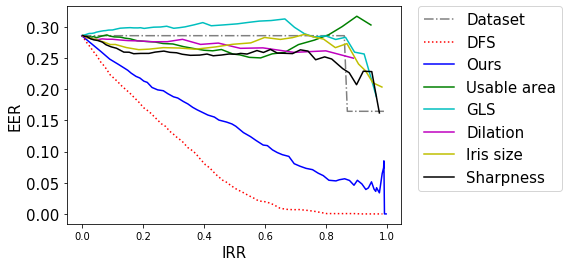

In [166]:
plt.figure()

plt.plot(x, y, linestyle='-.',color='gray', label='Dataset')
plt.plot(t_irr_list, t_eer_list, color='r',linestyle=':',  label='DFS')
plt.plot(p_irr_list, p_eer_list, color='b', label='Ours')
plt.plot(uar_irr_list, uar_eer_list, color='g', label='Usable area')
plt.plot(gls_irr_list, gls_eer_list, color='c', label='GLS')
plt.plot(dilation_irr_list, dilation_eer_list, color='m', label='Dilation')
plt.plot(size_irr_list, size_eer_list, color='y', label='Iris size')
plt.plot(fm_irr_list, fm_eer_list, color='k', label='Sharpness')

# plt.xlim(-0.005,0.95)
# plt.ylim(-0.005,0.35)
plt.xlabel('IRR', fontsize=15)
plt.ylabel('EER', fontsize=15)
# plt.xticks(np.arange(0,1,0.1), fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0, fontsize=15)
plt.savefig('result/eer_irr_hd_TJ.png')
plt.show()

In [152]:
def pre(eer, irr):
    return [int(eer[np.argmin(np.abs(irr - x))]*100*100)/100 for x in [0, 0.25, 0.5, 0.75, 0.95]]

t_irr = np.array(t_irr_list)
t_eer = np.array(t_eer_list)
print('t', pre(t_eer,t_irr),len(t_irr))

p_irr = np.array(p_irr_list)
p_eer = np.array(p_eer_list)
print('p', pre(p_eer,p_irr),len(p_irr))

fm_irr = np.array(fm_irr_list)
fm_eer = np.array(fm_eer_list)
print('fm', pre(fm_eer,fm_irr),len(fm_irr))

size_irr = np.array(size_irr_list)
size_eer = np.array(size_eer_list)
print('size', pre(size_eer,size_irr),len(size_irr))

uar_irr = np.array(uar_irr_list)
uar_eer = np.array(uar_eer_list)
print('uar', pre(uar_eer,uar_irr),len(uar_irr))

gls_irr = np.array(gls_irr_list)
gls_eer = np.array(gls_eer_list)
print('gls', pre(gls_eer,gls_irr),len(gls_irr))

dilation_irr = np.array(dilation_irr_list)
dilation_eer = np.array(dilation_eer_list)
print('dilation', pre(dilation_eer,dilation_irr),len(dilation_irr))

t [28.59, 15.23, 3.92, 0.56, 0.0] 100
p [28.59, 19.89, 14.06, 7.09, 5.14] 77
fm [28.6, 25.95, 25.61, 26.11, 22.82] 49
size [28.63, 26.67, 27.2, 28.4, 21.03] 49
uar [28.53, 27.56, 25.64, 27.88, 30.3] 49
gls [28.64, 29.98, 30.48, 28.39, 18.85] 49
dilation [28.52, 27.61, 26.56, 26.15, 24.98] 49
